Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


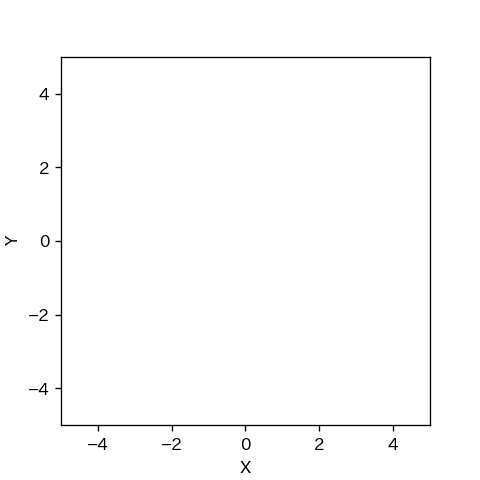

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap_phantom_trap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


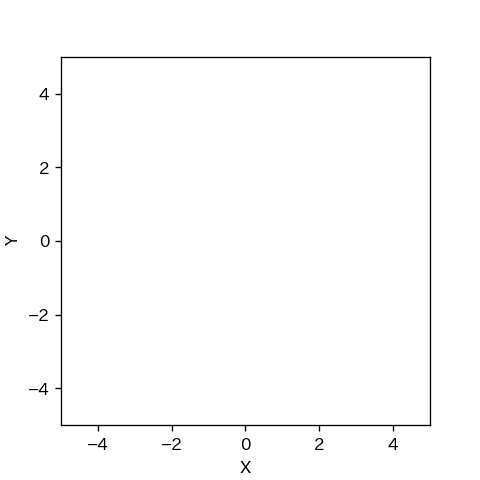

(array([-2.77871728, -0.14360274,  2.69383162]),
 array([ 1.4361713 , -0.69220902,  2.85265309]))

In [4]:
trial_kidnap_phantom_trap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap_phantom_trap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [ 2.46772631 -1.05494033  0.00673073] 推定値: [ 0.96317204 -4.29989022  2.97852532] 誤差: 3.5767839443950713
1 真値: [ 0.70773145 -2.9763308   4.34891358] 推定値: [ 0.28142724 -0.75135382  6.53420234] 誤差: 2.26544870398964
2 真値: [3.35119259 4.94550216 1.00834931] 推定値: [1.73178428 0.97194197 4.62771028] 誤差: 4.290881470572409
3 真値: [-3.60662012 -2.76427618  5.17713482] 推定値: [-0.06503017  5.58346444  1.2429147 ] 誤差: 9.067945342385388
4 真値: [3.37870689 6.44552417 2.9138111 ] 推定値: [-0.73511349  2.16455705  7.78913546] 誤差: 5.937187677330971
5 真値: [-2.57837516  2.62722801  1.37904884] 推定値: [-2.28111083  3.40751081  7.5781416 ] 誤差: 0.8349894168279338
1
6 真値: [-0.51873595 -2.59160453  2.43943102] 推定値: [-9.25841471  4.76987297 -0.23526393] 誤差: 11.426869032993414
7 真値: [0.17198879 6.7499766  1.97048922] 推定値: [ 1.22110129 -2.30828615  7.134558  ] 誤差: 9.118813582078094
8 真値: [-6.32187378  2.38295796  4.40281962] 推定値: [ 0.49109217 -4.37480288  9.2723918 ] 誤差: 9.596032340773885
9 真値: [ 1.2900204  -0.73921

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-5.99668066  2.63746709  4.44130513] 推定値: [-3.90522278 -2.25938884  7.49104305] 誤差: 5.324790524584444
21 真値: [-2.84963993 -3.61707575  4.82046759] 推定値: [-0.71490222 -6.00066012  5.72061584] 誤差: 3.199778046484938
22 真値: [-3.86074302 -3.14212773  5.0449457 ] 推定値: [ 0.62610087 -0.71228024  7.16432451] 誤差: 5.102541224598152
23 真値: [-3.85117247 -3.51032496  5.78416756] 推定値: [ 2.96607325 -8.57649364  1.19106815] 誤差: 8.493580186403424
24 真値: [5.60531527 0.77551594 1.83939854] 推定値: [6.67333995 2.45561485 2.40752314] 誤差: 1.990831251121534
25 真値: [-1.9102505   1.39003368  5.46230029] 推定値: [ 3.40541558  4.46039159 -1.85120378] 誤差: 6.138680926921288
26 真値: [ 2.64967575 -5.52369258  7.16402749] 推定値: [ 0.13963762 -1.75057453  4.78149913] 誤差: 4.531744831422873
27 真値: [-0.78232125  5.12173907  3.11194415] 推定値: [1.05475429 0.47681145 1.99774663] 誤差: 4.9950174324973755
28 真値: [ 5.55281439 -4.48075131  0.63163858] 推定値: [5.15989069 0.90575771 3.05562948] 誤差: 5.400821084660937
29 真値: [-1.71420771 -